In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import io
from collections import defaultdict

In [157]:
pd.options.display.max_columns = None

### Stochastic Differential Equation for Hull White

$dr = \left( \theta(t) - a r(t) \right) dt + \sigma W(t)$

Discrete

$\Delta r = r(t_{i+1}) - r(t_{i}) = \left( \theta(t_{i}) - a r(t_{i}) \right) \left( t_{i+1} - t_{i} \right) + \sigma \left( W(t_{i+1}) - W(t_{i}) \right)$

### input parameter

In [133]:
a = 0.1
sigma = 0.01
delta_t = 0.25
h = 3
is_aprrox_m_v = 1

In [134]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

class Hull_White_binom_tree:
    def __init__(self, a, sigma, delta_t, h, is_approx_m_v):
        self._a = a
        self._sigma = sigma
        self._delta_t = delta_t
        self._h = h
        self._is_approx_m_v = is_approx_m_v
        self._M = - (self._a * self._delta_t)
        self._V = self._sigma ** 2 * self._delta_t
        self._jmax = int(np.ceil(- (1 - np.sqrt( 1 - 1 / self._h)) / self._M))
        self._len_ir = self._jmax * 2 + 1
    
    def calc_pu(self, j, tree_type):
        if tree_type == 0:
            return  (( 1/ self._h) + j ** 2 * self._M ** 2 + j * self._M ) / 2
        elif tree_type == -1:
            return  1 + 1 / 2 * (( 1/ self._h) + j ** 2 * self._M ** 2 + 3* j * self._M )
        elif tree_type == 1:
            return 1 / 2 * (( 1/ self._h) + j ** 2 * self._M ** 2 - j * self._M )
        
    def calc_pm(self, j, tree_type):
        if tree_type== 0:
            return  1 - 1 / self._h - j ** 2 * self._M ** 2
        elif tree_type == -1:
            return  - (( 1/ self._h) + j ** 2 * self._M ** 2 + 2 * j * self._M )
        elif tree_type == 1:
            return - (( 1/ self._h) + j ** 2 * self._M ** 2 - 2 * j * self._M )
        
    def calc_pd(self, j, tree_type):
        if tree_type == 0:
            return  1 / 2 * (( 1/ self._h) + j ** 2 * self._M ** 2 - j * self._M )
        elif tree_type == -1:
            return  1 / 2 * (( 1/ self._h) + j ** 2 * self._M ** 2 + j * self._M )
        elif tree_type == 1:
            return 1+ 1 / 2 * (( 1/ self._h) + j ** 2 * self._M ** 2 - 3 * j * self._M )
        
    def array_normal(self):
        return np.arange(- self._jmax + 1, self._jmax)
    
    def array_pu(self):
        array_pu = np.zeros(self._len_ir)
        array_pu[0] = self.calc_pu(- self._jmax, 1)
        array_pu[-1] = self.calc_pu(self._jmax, -1) 
        array_pu[1:-1] = self.calc_pu(self.array_normal(), 0)
        return array_pu
    
    def array_pm(self):
        array_pm = np.zeros(self._len_ir)
        array_pm[0] = self.calc_pm(- self._jmax, 1)
        array_pm[-1] = self.calc_pm(self._jmax, -1) 
        array_pm[1:-1] = self.calc_pm(self.array_normal(), 0)
        return array_pm
    
    def array_pd(self):
        array_pd = np.zeros(self._len_ir)
        array_pd[0] = self.calc_pd(- self._jmax, 1)
        array_pd[-1] = self.calc_pd(self._jmax, -1) 
        array_pd[1:-1] = self.calc_pd(self.array_normal(), 0)
        return array_pd
    
    def transition_prob(self):
        array_tran_prob = np.zeros(((self._jmax * 2 + 1), 4))
        array_tran_prob[:, 0] = np.arange(-self._jmax, self._jmax + 1)
        array_tran_prob[:, 1] = self.array_pu()
        array_tran_prob[:, 2] = self.array_pm()
        array_tran_prob[:, 3] = self.array_pd()
        return array_tran_prob[::-1]
    
    def transition_prob_df(self):
        tmp_df = pd.DataFrame(self.transition_prob(), columns=['index', 'Pu', 'Pm', 'Pd'])
        tmp_df['index'] = tmp_df['index'].astype(int)
        return tmp_df
    
    @property
    def a(self):
        return self._a
    
    @property
    def M(self):
        return self._M
    
    @property
    def V(self):
        return self._V
    
    @property
    def jmax(self):
        return self._jmax

In [191]:
tree_obj = Hull_White_binom_tree(a, sigma, delta_t, h, is_aprrox_m_v)
print(tree_obj.a)
print(tree_obj.V)
print(tree_obj.M)
print(tree_obj.jmax)
df_prob = tree_obj.transition_prob_df().set_index('index')
df_prob

0.1
2.5e-05
-0.025
8


,Pu,Pm,Pd
index,,,
8,0.886667,0.026667,0.086667
7,0.094479,0.636042,0.269479
6,0.102917,0.644167,0.252917
5,0.111979,0.651042,0.236979
4,0.121667,0.656667,0.221667
3,0.131979,0.661042,0.206979
2,0.142917,0.664167,0.192917
1,0.154479,0.666042,0.179479
0,0.166667,0.666667,0.166667


In [196]:
df_prob.head()

,Pu,Pm,Pd
index,,,
8,0.886667,0.026667,0.086667
7,0.094479,0.636042,0.269479
6,0.102917,0.644167,0.252917
5,0.111979,0.651042,0.236979
4,0.121667,0.656667,0.221667


In [430]:
test_list = []
for i in range(len(df_ois)):
    emp_list = [0 for i in range(i * 2 + 1)]
    if len(emp_list) > 8:
        emp_list = [0] * 8
        test_list.append(emp_list)
    else:
        test_list.append(emp_list)

In [431]:
tree_list = np.zeros((8 * 2 +1, len(df_ois)))
df_tree = pd.DataFrame(tree_list, index=df_prob.index)
df_tree.loc[0,0] = 1.0
df_tree.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
index,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [432]:
upper_idx = 8
for j in range(1, 27):
    index_list = (np.arange(j * 2 + 1) - j)[::-1]
    if len(index_list) > (2 * upper_idx + 1):
        index_list = np.arange(-upper_idx, upper_idx+1)[::-1]
    else:
        pass
    print(index_list)
    for i in index_list:
        if (i >=upper_idx):
            df_tree.loc[upper_idx, j] = df_tree.loc[upper_idx-1, j -1] * df_prob.loc[upper_idx-1, 'Pu'] +\
                                                            df_tree.loc[upper_idx, j-1]* df_prob.loc[upper_idx, 'Pu']
        elif(i == upper_idx -1):
            df_tree.loc[i, j] = df_tree.loc[i+1, j -1] * df_prob.loc[i+1, 'Pm'] +\
                                                df_tree.loc[i, j-1]* df_prob.loc[i, 'Pm'] + df_tree.loc[i-1, j-1] * df_prob.loc[i-1, 'Pu']
        elif(i == upper_idx -2):
            df_tree.loc[i, j] = df_tree.loc[i+2, j -1] * df_prob.loc[i+2, 'Pd'] + df_tree.loc[i+1, j-1] * df_prob.loc[i+1, 'Pd'] +\
                                                df_tree.loc[i, j-1] * df_prob.loc[i, 'Pm'] + df_tree.loc[i-1, j-1] * df_prob.loc[i-1, 'Pu']
        elif (i <= - upper_idx):
            df_tree.loc[-upper_idx, j] = df_tree.loc[-upper_idx+1, j -1] * df_prob.loc[-upper_idx+1, 'Pd'] +\
                                                            df_tree.loc[-upper_idx, j-1]* df_prob.loc[-upper_idx, 'Pd']
        elif(i == - upper_idx + 1):
            df_tree.loc[i, j] = df_tree.loc[i+1, j -1] * df_prob.loc[i+1, 'Pd'] +\
                                                df_tree.loc[i, j-1]* df_prob.loc[i, 'Pm'] + df_tree.loc[i-1, j-1] * df_prob.loc[i-1, 'Pm']
        elif(i == - upper_idx + 2):
            df_tree.loc[i, j] = df_tree.loc[i+1, j -1] * df_prob.loc[i+1, 'Pd'] + df_tree.loc[i, j-1] * df_prob.loc[i, 'Pm'] + \
                                                df_tree.loc[i-1, j-1] * df_prob.loc[i-1, 'Pu'] + df_tree.loc[i-2, j-1] * df_prob.loc[i-2, 'Pu']
        else:
            df_tree.loc[i, j] = df_tree.loc[i+1, j - 1] * df_prob.loc[i+1, 'Pd'] + \
                                        df_tree.loc[i, j -1] * df_prob.loc[i, 'Pm'] + df_tree.loc[i-1, j-1]* df_prob.loc[i-1, 'Pu']

[ 1  0 -1]
[ 2  1  0 -1 -2]
[ 3  2  1  0 -1 -2 -3]
[ 4  3  2  1  0 -1 -2 -3 -4]
[ 5  4  3  2  1  0 -1 -2 -3 -4 -5]
[ 6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6]
[ 7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]
[ 

In [433]:
df_tree

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
index,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,6.433355e-08,3.945255e-07,0.000001,0.000003,0.000007,0.000014,0.000023,0.000036,0.000053,0.000074,0.000099,0.000129,0.000163,0.000202,0.000244,0.000290,0.000338,0.000390,0.000445
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.809285e-07,3.572037e-06,1.070121e-05,0.000024,0.000045,0.000076,0.000115,0.000164,0.000221,0.000286,0.000358,0.000435,0.000517,0.000601,0.000688,0.000777,0.000866,0.000954,0.001042,0.001129
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000007,3.049981e-05,8.188691e-05,1.678872e-04,0.000292,0.000453,0.000650,0.000877,0.001131,0.001405,0.001695,0.001996,0.002305,0.002617,0.002929,0.003240,0.003547,0.003849,0.004143,0.004430,0.004709
5,0.0,0.000000,0.000000,0.000000,0.000000,0.000059,0.000234,5.541786e-04,1.019567e-03,1.613539e-03,0.002311,0.003084,0.003909,0.004764,0.005630,0.006494,0.007347,0.008179,0.008986,0.009764,0.010511,0.011225,0.011906,0.012554,0.013170,0.013754,0.014307
4,0.0,0.000000,0.000000,0.000000,0.000486,0.001610,0.003287,5.351176e-03,7.636008e-03,1.001014e-02,0.012380,0.014683,0.016883,0.018959,0.020902,0.022711,0.024389,0.025942,0.027377,0.028702,0.029926,0.031057,0.032101,0.033067,0.033960,0.034787,0.035554
3,0.0,0.000000,0.000000,0.003680,0.009780,0.016793,0.023769,3.023765e-02,3.602245e-02,4.109774e-02,0.045509,0.049327,0.052629,0.055489,0.057972,0.060133,0.062020,0.063673,0.065126,0.066408,0.067543,0.068550,0.069447,0.070248,0.070965,0.071610,0.072190
2,0.0,0.000000,0.025747,0.051413,0.071512,0.086141,0.096538,1.038922e-01,1.091038e-01,1.128092e-01,0.115448,0.117324,0.118648,0.119569,0.120193,0.120595,0.120833,0.120948,0.120970,0.120923,0.120825,0.120688,0.120524,0.120341,0.120145,0.119940,0.119731
1,0.0,0.166667,0.222118,0.236952,0.237057,0.232074,0.225630,2.190812e-01,2.129105e-01,2.072626e-01,0.202151,0.197541,0.193384,0.189629,0.186229,0.183142,0.180333,0.177768,0.175421,0.173269,0.171289,0.169466,0.167782,0.166225,0.164783,0.163444,0.162200
0,1.0,0.666667,0.504271,0.415912,0.362330,0.326647,0.301070,2.817049e-01,2.664443e-01,2.540555e-01,0.243769,0.235076,0.227627,0.221168,0.215514,0.210524,0.206090,0.202125,0.198562,0.195343,0.192425,0.189769,0.187344,0.185123,0.183083,0.181205,0.179473


$A[i , j] = A[i+1, j-1] \times P_{d}(i+1) + A[i, j-1] \times P_{m}(i) + A[i-1, j-1] \times P_{u}(i-1)$

In [393]:
index_list[np.where((-8 <= index_list) & (index_list <= 8), True, False)]

array([ 8,  7,  6,  5,  4,  3,  2,  1,  0, -1, -2, -3, -4, -5, -6, -7, -8])

In [282]:
scenario_list = {1:'Pu', 0: 'Pm', -1:'Pd'}
scenario_list[-1]

'Pd'

In [269]:
k = 1
np.arange(k * 2+ 1) - 1

array([-1,  0,  1])

In [301]:
0.666667 * 0.666667

0.444444888889

In [98]:
df_ois['index'].head()

0    0
1    1
2    2
3    3
4    4
Name: index, dtype: int64

In [99]:
txt = """
1.0
0.998360233
0.997047454
0.995728200
0.994227469
0.992416310
0.990090443
0.987984541
0.985438802
0.982069456
0.977639885
0.972136997
0.966008578
0.959495647
0.951990000
0.944242590
0.936095961
0.927614872
0.918849472
0.909738452
0.900521345
0.891235305
0.881616397
0.871915175
0.862283963
0.852768627
0.843099266
"""
ioo = io.StringIO(txt)
list_ois = list(map(lambda x: float(x), ioo.getvalue().split()))
list_date = np.arange(0, 6.75, 0.25)

TypeError: 'list' object is not callable

In [43]:
df_ois = pd.DataFrame({'date': list_date, 'ois_discount': list_ois})
df_ois = df_ois.reset_index()
df_ois['ln_ois_discount'] = np.log(df_ois['ois_discount']) * -1
df_ois['short_rate'] = df_ois['ln_ois_discount'] / df_ois['date']
df_ois.head()

,index,date,ois_discount,ln_ois_discount,short_rate
0,0,0.00,1.000000,-0.000000,NaN
1,1,0.25,0.998360,0.001641,0.006564
2,2,0.50,0.997047,0.002957,0.005914
3,3,0.75,0.995728,0.004281,0.005708
4,4,1.00,0.994227,0.005789,0.005789


## forward induction
1. $m+1$のゼロクーポンボンドにキャリブレーションする($\alpha(m)$を求める)
    - $\left[Q(m,j; p(m-1, j), \alpha(m-1)), P(0, (m+1)\Delta t \right] \rightarrow \alpha(m)$ 
    
$$\alpha(m) = \frac{1}{\Delta t}\left( \ln \Big( \Sigma_{j} Q(m, j) \exp \big( - j \Delta r \Delta t \big) \Big) - \ln \big( P(0, (m+1)\Delta t)\big) \right)$$
    
1. 1.で求めた$\alpha(m)$を用いて，$m+1$のアロードブリュー証券の価値を求める($Q(m+1, j)$)
    - $\left[\alpha(m), p(k, j), Q(m,j; p(m-1, j), \alpha(m-1)) \right] \rightarrow Q(m+1, j)$
    
$$ Q(m+1, j) = \Sigma_{k} Q(k, j) p(k, j) \exp\Big( \left(\alpha(m) + k \Delta r \right) \Delta t \Big) $$

$r(m, j) = \alpha(m) + j \Delta r$

$\Delta r = \sqrt{h V}$

$V = \sigma \sqrt{\Delta t}$

In [7]:
ad_initial = 1.0

In [214]:
index_list[::-1]

array([ 1,  0, -1])

In [25]:
alpha_list = np.zeros(len(df_ois))

In [52]:
sigma
delta_t

0.25

In [53]:
df_ois['date']

0     0.00
1     0.25
2     0.50
3     0.75
4     1.00
5     1.25
6     1.50
7     1.75
8     2.00
9     2.25
10    2.50
11    2.75
12    3.00
13    3.25
14    3.50
15    3.75
16    4.00
17    4.25
18    4.50
19    4.75
20    5.00
21    5.25
22    5.50
23    5.75
24    6.00
25    6.25
26    6.50
Name: date, dtype: float64

In [6]:
from collections import defaultdict
df_test = pd.DataFrame({'date': ['2018-07-31', '2019-07-31', '2018-07-31', '2019-07-31'], \
                        'values':[10, 30, 20, 40], \
                        'model': ['MODEL', 'MODEL', 'MODEL', 'MODEL'], \
                        'id':['1', '1', '2', '2']})
model_unmodel_list = ['MODEL', 'UNMODEL']
netset_list = ['1', '2']
dict_date = defaultdict(lambda: defaultdict(int))
for i in range(2):
    for j in range(2):
        df_test_ = df_test[(df_test['model'] == model_unmodel_list[i]) & (df_test['id'] == netset_list[j])]
        try:
            last_date = df_test_['date'].iloc[-1]
        except IndexError:
            print('index-error')
        else:
            dict_date[model_unmodel_list[i]][netset_list[j]] = last_date
dict_date

index-error
index-error


defaultdict(<function __main__.<lambda>>,
            {'MODEL': defaultdict(int,
                         {'1': '2019-07-31', '2': '2019-07-31'})})

## 別のやつ

In [6]:
df_test = pd.DataFrame({'date': ['2018-07-31', '2019-07-31', '2020-07-31', '2018-07-31', '2019-07-31'], \
                        'values':[10, 30, 20, 20, 40], \
                        'model': ['MODEL', 'MODEL', 'MODEL', 'MODEL', 'MODEL'], \
                        'id':['1', '1', '1', '2', '2']})

In [11]:
df_test.groupby('date').sum()

,values
date,
2018-07-31,30
2019-07-31,70
2020-07-31,20


In [21]:
np.random.rand(5) * 10

array([5.6298631 , 9.73702789, 0.36575975, 2.13668672, 4.87427057])

In [ ]:
trade_list = []
for i in range(20):
    str_trade = 'trade' + str(i)
    trade_list.append(str_trade)

In [27]:
df_test_2 = pd.DataFrame({'trade_num': trade_list,\
                          'pe0': np.random.rand(20) * 10,\
                         'mtm': np.random.randn(20)*5})

In [40]:
df_test_2['ratio'] = df_test_2['pe0'] / df_test_2['mtm']
df_test_2['labels'] = pd.cut(df_test_2['ratio'], bins=[-10, 0, 5, 10, 15, 20], labels=False)

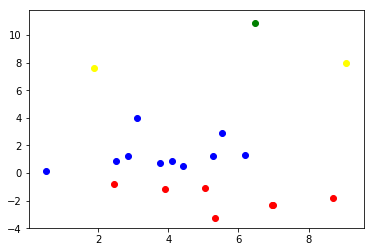

In [54]:
label_list = sorted(df_test_2['labels'].unique())
color_list = ['red', 'blue', 'yellow', 'green']
fig = plt.figure()
for i in range(len(label_list)):
    df_target = df_test_2[df_test_2['labels'] == label_list[i]]
    plt.scatter(df_target['pe0'], df_target['ratio'], color=color_list[i])